In [1]:
import numpy as np, matplotlib.pyplot as plt
from math import pi

Параметры заданные преподавателем:

$$ c = 1,65 $$
$$ k = 0,59 $$
$$ R = 5 $$
$$ u_c = 0 $$
$$ l = 0,5 $$
$$ \alpha = 0,003 $$
$$ T = 40 $$
$$ \psi(\theta) = u_c + cos^4 (\theta) $$

In [2]:
c = 1.65
k = 0.59
R = 5
uc = 0
l = 0.5
alpha = 0.003
T = 40

def psi(theta):
    return uc + np.cos(theta) ** 4

I = 1024
K = 1024
t = np.linspace(0, T, I + 1)
tht = np.linspace(0.001, pi-0.001, K + 1)

Начальное распределение температуры:

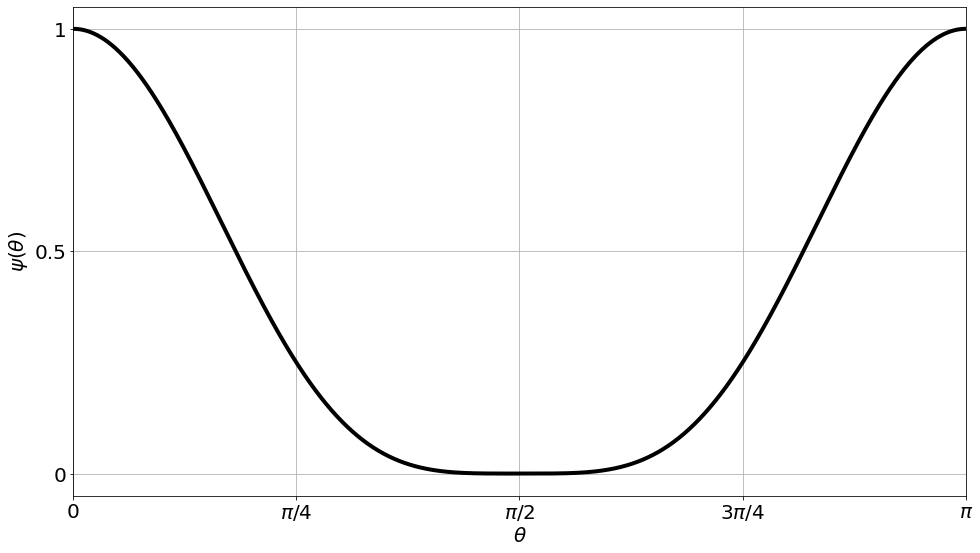

In [3]:
f = plt.figure(figsize=[16, 9])
plt.plot(tht, psi(tht), lw=4, c='black')
plt.xlim([tht[1], tht[-1]])
plt.xlabel('${\\theta}$', fontsize=20)
plt.ylabel('${\\psi(\\theta)}$', fontsize=20)
plt.xticks([0, pi/4, pi/2, 3*pi/4, pi], ['0', '$\\pi / 4$', '$\\pi / 2$', '$3 \\pi / 4$', '$\\pi$'], fontsize=20)
plt.yticks([0, 0.5, 1], ['0', '0.5', '1'], fontsize=20)
plt.grid()
plt.show()

In [4]:
ht = t[2] - t[1]
htht = tht[2] - tht[1]

In [5]:
A = k / (c * R ** 2)
B = alpha / (c * l)

beta_c = B * ht + 2 * A * ht / (htht ** 2) + 1
gam = -A * ht / (htht ** 2) * (1 + htht / (2 * np.tan(tht[:-1])))
eps = -A * ht / (htht ** 2) * (1 - htht / (2 * np.tan(tht[1:])))
eta = B * ht * uc

mu = B * ht + 4 * A * ht / (htht ** 2) + 1
sigma = - 2 * A * ht / (htht ** 2) 

In [6]:
v = np.zeros([K + 1, I + 1])
v[0, :] = psi(tht)

In [7]:
# def TDMASolve(a, b, c, d):
#     n = len(a)
#     ac, bc, cc, dc = map(np.array, (a, b, c, d))
#     xc = []
#     for j in range(1, n):
#         if(bc[j - 1] == 0):
#             ier = 1
#             return
#         ac[j] = ac[j]/bc[j-1]
#         bc[j] = bc[j] - ac[j]*cc[j-1]
#     if(b[n-1] == 0):
#         ier = 1
#         return
#     for j in range(1, n):
#         dc[j] = dc[j] - ac[j]*dc[j-1]
#     dc[n-1] = dc[n-1]/bc[n-1]
#     for j in range(n-2, -1, -1):
#         dc[j] = (dc[j] - cc[j]*dc[j+1])/bc[j]
#     return dc

In [8]:
# beta = beta_c * np.ones(I + 1)
# eps[-1] = sigma
# gam[0] = sigma

# for k_ind in range(1,K+1):
#     v[k_ind, :] = TDMASolve(eps, beta, gam, v[k_ind - 1, :])

In [9]:
beta = beta_c * np.ones(I + 1)
eps[-1] = sigma
gam[0] = sigma

matrix = np.diag(beta) + np.diag(eps, -1) + np.diag(gam, 1)

for k_ind in range(1,K+1):
    v[k_ind, :] = np.linalg.inv(matrix) @ v[k_ind - 1, :]

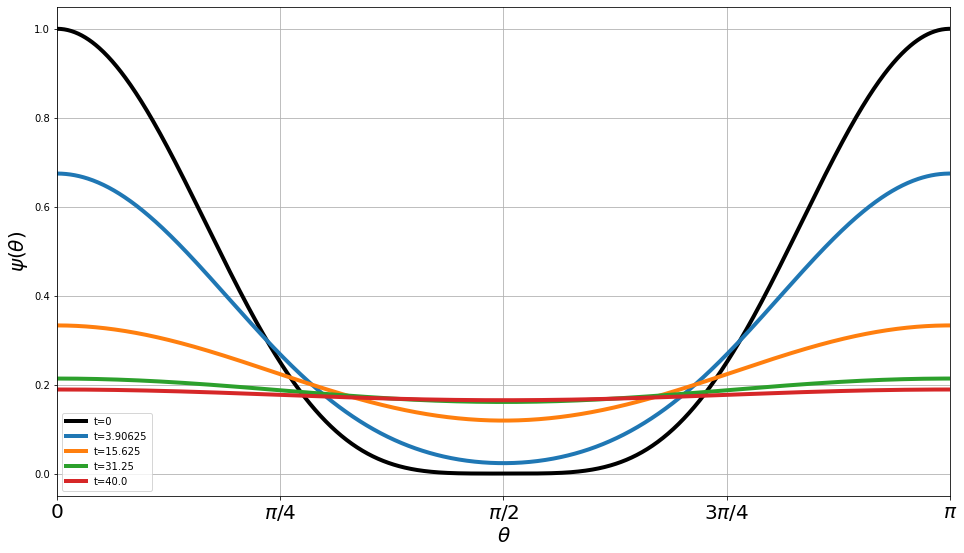

In [10]:
f = plt.figure(figsize=[16, 9])
plt.plot(tht, v[0, :], lw=4, c='black', label='t=0')
for ind in [100, 400, 800, 1024]:
    plt.plot(tht, v[ind, :], lw=4, label='t='+str(t[ind]))

plt.xlim([tht[1], tht[-1]])
plt.xlabel('${\\theta}$', fontsize=20)
plt.ylabel('${\\psi(\\theta)}$', fontsize=20)
plt.xticks([0, pi/4, pi/2, 3*pi/4, pi], ['0', '$\\pi / 4$', '$\\pi / 2$', '$3 \\pi / 4$', '$\\pi$'], fontsize=20)
# plt.yticks([0, 0.5, 1], ['0', '0.5', '1'], fontsize=20)
plt.legend()
plt.grid()
plt.show()

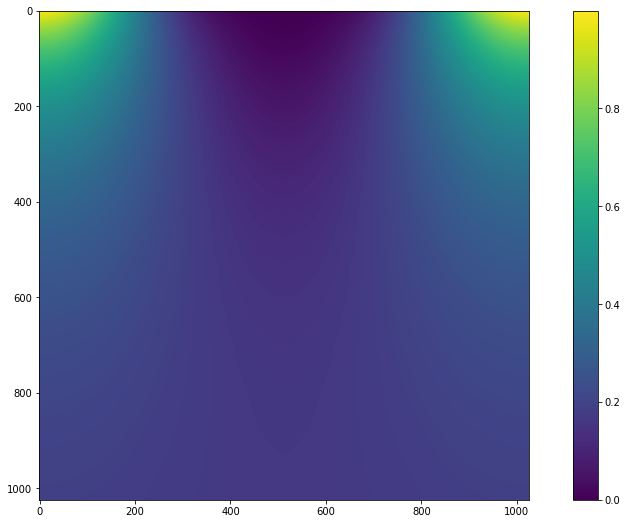

In [11]:
f = plt.figure(figsize=[16, 9])
plt.imshow(v)
plt.colorbar()
plt.show()

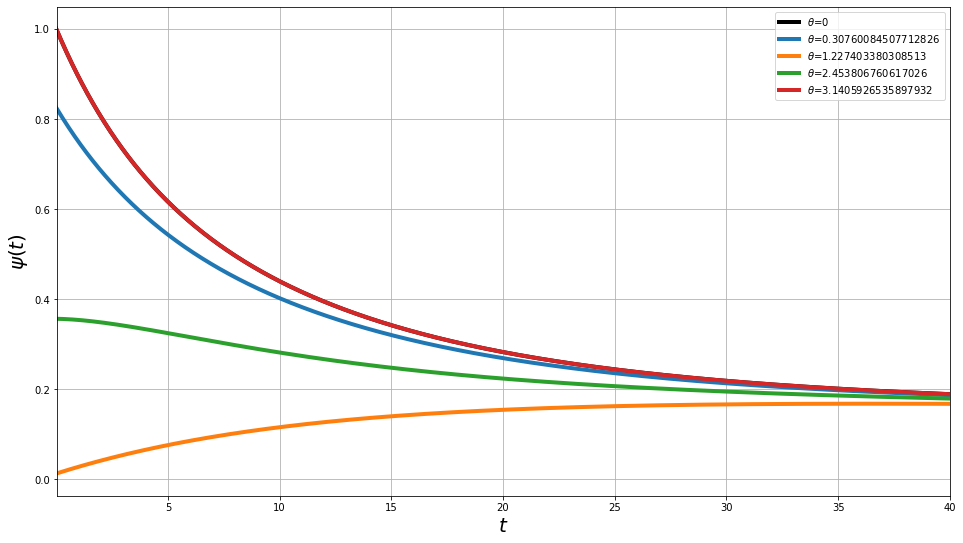

In [12]:
f = plt.figure(figsize=[16, 9])
plt.plot(t, v[:, 0], lw=4, c='black', label='$\\theta$=0')
for ind in [100, 400, 800, 1024]:
    plt.plot(t, v[:, ind], lw=4, label='$\\theta$='+str(tht[ind]))
plt.xlim([t[1], t[-1]])
plt.xlabel('$t$', fontsize=20)
plt.ylabel('${\\psi(t)}$', fontsize=20)
plt.legend()
plt.grid()
plt.show()

Простейшая неявная схема